# Unicycle Model Demo

This notebook demonstrates all controllers for the discrete-time unicycle (nonholonomic mobile robot).

## Model Specification (from Symbolic_control_lecture-7.pdf)

$$x_1(t+1) = x_1(t) + \tau (v(t) \cos(\theta(t)) + w_1(t))$$
$$x_2(t+1) = x_2(t) + \tau (v(t) \sin(\theta(t)) + w_2(t))$$
$$\theta(t+1) = \theta(t) + \tau (\omega(t) + w_3(t))$$

- State: $[x, y, \theta]$ (position and heading)
- Input: $[v, \omega]$ (forward velocity and angular velocity)
- Input constraints: $v \in [0.25, 1]$, $\omega \in [-1, 1]$

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow

from models.unicycle import UnicycleModel
from controllers.unicycle import (
    FeedbackLinearizationController,
    PolarCoordinateController,
    SlidingModeController,
    UnicycleLQRController
)
from sim.simulator import Simulator

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

## 1. Setup Model and Configuration

In [2]:
# Create model
model = UnicycleModel(tau=0.1)
print(f"Model: {model}")
print(f"State bounds: {model.x_bounds}")
print(f"Input bounds: {model.u_bounds}")

# Configuration
x0 = np.array([2.0, 2.0, 0.0])  # Start at (2,2) facing right
target = np.array([8.0, 8.0, np.pi/2])  # Go to (8,8) facing up
T = 20.0  # Simulation time

print(f"\nStart: ({x0[0]}, {x0[1]}), heading={np.degrees(x0[2]):.1f} deg")
print(f"Target: ({target[0]}, {target[1]}), heading={np.degrees(target[2]):.1f} deg")

Model: UnicycleModel(tau=0.1)
State bounds: [[ 0.         10.        ]
 [ 0.         10.        ]
 [-3.14159265  3.14159265]]
Input bounds: [[ 0.25  1.  ]
 [-1.    1.  ]]

Start: (2.0, 2.0), heading=0.0 deg
Target: (8.0, 8.0), heading=90.0 deg


## 2. Feedback Linearization Controller

Uses a reference point ahead of the robot to linearize the nonlinear dynamics.

Reference point: $(x_r, y_r) = (x + d\cos\theta, y + d\sin\theta)$

In [3]:
# Feedback Linearization
fb_ctrl = FeedbackLinearizationController(d=0.3, kp=1.0, name="FeedbackLin")
fb_ctrl.set_model(model)
fb_ctrl.set_target(target)

# Stability analysis
stability = fb_ctrl.analyze_stability()
print("Feedback Linearization:")
print(f"  Reference point distance: d = {fb_ctrl.d}")
print(f"  Stability: {stability}")

# Simulate
sim = Simulator(model, fb_ctrl, disturbance_mode='random', seed=42)
fb_result = sim.run(x0, T, target)

print(f"\nFinal position error: {np.linalg.norm(fb_result.states[-1, :2] - target[:2]):.4f}")

Feedback Linearization:
  Reference point distance: d = 0.3
  Stability: {'eigenvalue': 0.9, 'is_stable': True, 'stability_margin': 0.09999999999999998, 'recommended_kp_range': (0, 20.0), 'note': 'Stability assumes perfect linearization (no disturbance)'}

Final position error: 0.1332


## 3. Polar Coordinate Controller

Uses polar error coordinates $(\rho, \alpha, \beta)$ for globally asymptotically stable regulation.

**Lyapunov Function:** $V = \frac{1}{2}(\rho^2 + \alpha^2 + k_\beta \beta^2)$

In [4]:
# Polar Coordinate Controller
polar_ctrl = PolarCoordinateController(k_rho=1.0, k_alpha=3.0, k_beta=-0.5, name="Polar")
polar_ctrl.set_model(model)
polar_ctrl.set_target(target)

# Verify stability conditions
stability = polar_ctrl.verify_stability_conditions()
print("Polar Coordinate Controller:")
print(f"  Gains: k_rho={polar_ctrl.k_rho}, k_alpha={polar_ctrl.k_alpha}, k_beta={polar_ctrl.k_beta}")
print(f"  Stability conditions satisfied: {stability['all_satisfied']}")

# Simulate
sim = Simulator(model, polar_ctrl, disturbance_mode='random', seed=42)
polar_result = sim.run(x0, T, target)

print(f"\nFinal position error: {np.linalg.norm(polar_result.states[-1, :2] - target[:2]):.4f}")

Polar Coordinate Controller:
  Gains: k_rho=1.0, k_alpha=3.0, k_beta=-0.5
  Stability conditions satisfied: True

Final position error: 0.4771


## 4. Sliding Mode Controller

Robust controller using sliding surfaces for position and heading.

Includes boundary layer to reduce chattering.

In [5]:
# Sliding Mode Controller
smc_ctrl = SlidingModeController(k_pos=2.0, k_theta=3.0, name="SMC")
smc_ctrl.set_model(model)
smc_ctrl.set_target(target)

# Robustness analysis
robustness = smc_ctrl.analyze_robustness()
print("Sliding Mode Controller:")
print(f"  Position gain: k_pos={smc_ctrl.k_pos}")
print(f"  Heading gain: k_theta={smc_ctrl.k_theta}")
print(f"  Disturbance rejection: {robustness['disturbance_rejection']}")

# Simulate
sim = Simulator(model, smc_ctrl, disturbance_mode='random', seed=42)
smc_result = sim.run(x0, T, target)

print(f"\nFinal position error: {np.linalg.norm(smc_result.states[-1, :2] - target[:2]):.4f}")

Sliding Mode Controller:
  Position gain: k_pos=2.0
  Heading gain: k_theta=3.0
  Disturbance rejection: Matched disturbances rejected when |d| < k

Final position error: 0.2466


## 5. LQR Controller (Linearized)

LQR applied to linearized unicycle dynamics around current heading.

In [6]:
# LQR Controller
lqr_ctrl = UnicycleLQRController(v_nom=0.5, name="LQR")
lqr_ctrl.set_model(model)
lqr_ctrl.set_target(target)

print("LQR Controller:")
print(f"  Nominal velocity: v_nom={lqr_ctrl.v_nom}")

# Simulate
sim = Simulator(model, lqr_ctrl, disturbance_mode='random', seed=42)
lqr_result = sim.run(x0, T, target)

# Analyze stability
stability = lqr_ctrl.analyze_stability()
print(f"  Local stability: {stability.get('is_locally_stable', 'N/A')}")
print(f"\nFinal position error: {np.linalg.norm(lqr_result.states[-1, :2] - target[:2]):.4f}")

LQR Controller:
  Nominal velocity: v_nom=0.5
  Local stability: True

Final position error: 2.7708


## 6. Visualization Helper

In [7]:
def plot_unicycle_trajectory(ax, states, color='blue', label=None, show_heading=True):
    """Plot unicycle trajectory with heading arrows."""
    ax.plot(states[:, 0], states[:, 1], '-', color=color, linewidth=1.5, label=label)
    
    if show_heading:
        # Show heading at intervals
        skip = max(1, len(states) // 10)
        for i in range(0, len(states), skip):
            x, y, theta = states[i]
            dx = 0.3 * np.cos(theta)
            dy = 0.3 * np.sin(theta)
            ax.arrow(x, y, dx, dy, head_width=0.15, head_length=0.1, 
                     fc=color, ec=color, alpha=0.5)

## 7. Controller Comparison

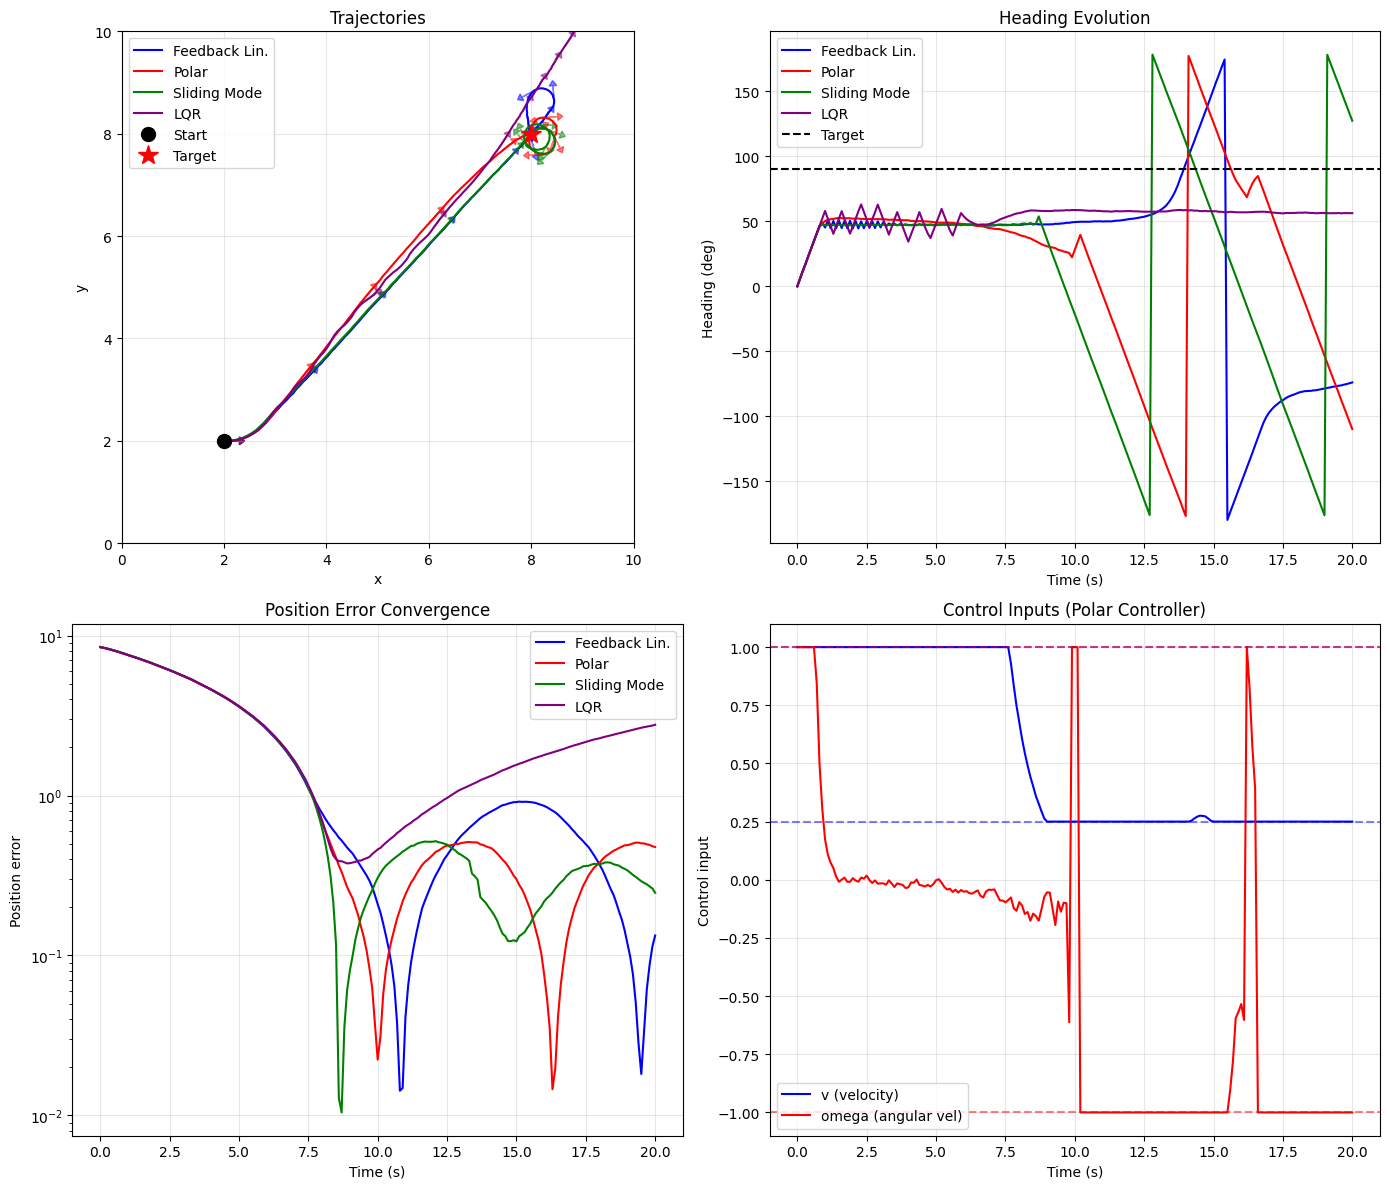


Performance Summary:
----------------------------------------------------------------------
Controller           Final Pos Error    Final Head Error   Energy         
----------------------------------------------------------------------
Feedback Lin.        0.1332             163.95             14.8688        
Polar                0.4771             199.79             19.4060        
Sliding Mode         0.2466             37.42              21.7833        
LQR                  2.7708             33.73              14.9941        


In [8]:
# Collect all results
results = [fb_result, polar_result, smc_result, lqr_result]
labels = ['Feedback Lin.', 'Polar', 'Sliding Mode', 'LQR']
colors = ['blue', 'red', 'green', 'purple']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Trajectories
ax = axes[0, 0]
for result, label, color in zip(results, labels, colors):
    plot_unicycle_trajectory(ax, result.states, color=color, label=label)
ax.plot(x0[0], x0[1], 'ko', markersize=10, label='Start')
ax.plot(target[0], target[1], 'r*', markersize=15, label='Target')
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Trajectories')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Heading evolution
ax = axes[0, 1]
for result, label, color in zip(results, labels, colors):
    ax.plot(result.time, np.degrees(result.states[:, 2]), '-', 
            color=color, linewidth=1.5, label=label)
ax.axhline(np.degrees(target[2]), color='k', linestyle='--', label='Target')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Heading (deg)')
ax.set_title('Heading Evolution')
ax.legend()
ax.grid(True, alpha=0.3)

# Position error
ax = axes[1, 0]
for result, label, color in zip(results, labels, colors):
    pos_errors = np.linalg.norm(result.states[:, :2] - target[:2], axis=1)
    ax.semilogy(result.time, pos_errors + 1e-10, '-', 
                color=color, linewidth=1.5, label=label)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Position error')
ax.set_title('Position Error Convergence')
ax.legend()
ax.grid(True, alpha=0.3)

# Control inputs for Polar controller
ax = axes[1, 1]
ax.plot(polar_result.time, polar_result.inputs[:, 0], 'b-', label='v (velocity)')
ax.plot(polar_result.time, polar_result.inputs[:, 1], 'r-', label='omega (angular vel)')
ax.axhline(model.u_bounds[0, 0], color='b', linestyle='--', alpha=0.5)
ax.axhline(model.u_bounds[0, 1], color='b', linestyle='--', alpha=0.5)
ax.axhline(model.u_bounds[1, 0], color='r', linestyle='--', alpha=0.5)
ax.axhline(model.u_bounds[1, 1], color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Control input')
ax.set_title('Control Inputs (Polar Controller)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance summary
print("\nPerformance Summary:")
print("-" * 70)
print(f"{'Controller':<20} {'Final Pos Error':<18} {'Final Head Error':<18} {'Energy':<15}")
print("-" * 70)
for result, label in zip(results, labels):
    pos_err = np.linalg.norm(result.states[-1, :2] - target[:2])
    head_err = np.abs(np.degrees(result.states[-1, 2] - target[2]))
    energy = result.compute_metrics()['input_energy']
    print(f"{label:<20} {pos_err:<18.4f} {head_err:<18.2f} {energy:<15.4f}")